In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "xxxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxxxx"

In [2]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.20G/1.21G [00:15<00:00, 64.1MB/s]
100% 1.21G/1.21G [00:15<00:00, 85.1MB/s]


In [0]:
!unzip celeba-dataset.zip > /dev/null

In [0]:
!unzip img_align_celeba.zip > /dev/null

In [6]:
!ls

celeba-dataset.zip    list_attr_celeba.csv     list_landmarks_align_celeba.csv
img_align_celeba      list_bbox_celeba.csv     sample_data
img_align_celeba.zip  list_eval_partition.csv


Loaded:  (25, 218, 178, 3)


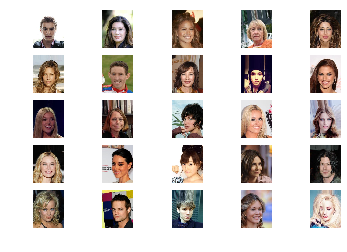

In [7]:
# load and plot faces
from os import listdir
from numpy import asarray
from PIL import Image
from matplotlib import pyplot

# load an image as an rgb numpy array
def load_image(filename):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	return pixels

# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# load the image
		pixels = load_image(directory + filename)
		# store
		faces.append(pixels)
		# stop once we have enough
		if len(faces) >= n_faces:
			break
	return asarray(faces)

# plot a list of loaded faces
def plot_faces(faces, n):
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(faces[i])
	pyplot.show()

# directory that contains all images
directory = 'img_align_celeba/'
# load and extract all faces
faces = load_faces(directory, 25)
print('Loaded: ', faces.shape)
# plot faces
plot_faces(faces, 5)

In [8]:
pip install mtcnn

     |████████████████████████████████| 2.3MB 4.1MB/s 
  Created wheel for mtcnn: filename=mtcnn-0.0.9-cp36-none-any.whl size=2257690 sha256=5880971b9209af3411c09cf0c7df77f57426c5b8604be18048e73766803eeec8
  Stored in directory: /root/.cache/pip/wheels/85/81/65/6363fa5aafd7a155c896591e0c7c6e27b69642aa82b9cbf076
Successfully built mtcnn


In [9]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.0.9


In [10]:
# example of extracting and resizing faces into a new dataset
from os import listdir
from numpy import asarray
from numpy import savez_compressed
from PIL import Image
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot

# load an image as an rgb numpy array
def load_image(filename):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	return pixels

# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(80, 80)):
	# detect face in the image
	faces = model.detect_faces(pixels)
	# skip cases where we could not detect a face
	if len(faces) == 0:
		return None
	# extract details of the face
	x1, y1, width, height = faces[0]['box']
	# force detected pixel values to be positive (bug fix)
	x1, y1 = abs(x1), abs(y1)
	# convert into coordinates
	x2, y2 = x1 + width, y1 + height
	# retrieve face pixels
	face_pixels = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face_pixels)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
	# prepare model
	model = MTCNN()
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# load the image
		pixels = load_image(directory + filename)
		# get face
		face = extract_face(model, pixels)
		if face is None:
			continue
		# store
		faces.append(face)
		# print(len(faces), face.shape)
		# stop once we have enough
		if len(faces) >= n_faces:
			break
	return asarray(faces)

# directory that contains all images
directory = 'img_align_celeba/'
# load and extract all faces
all_faces = load_faces(directory, 50000)
print('Loaded: ', all_faces.shape)
# save in compressed format
savez_compressed('img_align_celeba.npz', all_faces)






Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Loaded:  (50000, 80, 80, 3)


In [0]:
# example of a gan for generating faces
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 40x40
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 20x30
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 10x10
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 5x5
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 5x5 feature maps
	n_nodes = 128 * 5 * 5
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((5, 5, 128)))
	# upsample to 10x10
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 20x20
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 40x40
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 80x80
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer 80x80x3
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare training images
def load_real_samples():
	# load the face dataset
	data = load('img_align_celeba.npz')
	X = data['arr_0']
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			#print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
			#	(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Using TensorFlow backend.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_030.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 5)

In [0]:
# example of interpolating between generated faces
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n):
		# define subplot
		pyplot.subplot(1, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_030.h5')
# generate points in latent space
pts = generate_latent_points(100, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
X = model.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))

In [0]:
# example of interpolating between generated faces
from numpy import asarray
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy import linspace
from numpy.linalg import norm
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# spherical linear interpolation (slerp)
def slerp(val, low, high):
	omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
	so = sin(omega)
	if so == 0:
		# L'Hopital's rule/LERP
		return (1.0-val) * low + val * high
	return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = slerp(ratio, p1, p2)
		vectors.append(v)
	return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_030.h5')
# generate points in latent space
n = 20
pts = generate_latent_points(100, n)
# interpolate pairs
results = None
for i in range(0, n, 2):
	# interpolate points in latent space
	interpolated = interpolate_points(pts[i], pts[i+1])
	# generate images
	X = model.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))
# plot the result
plot_generated(results, 10)